# **Experiment #3**: Evaluation


In [1]:
import mne

# Utility
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import tensorflow as tf
# Scikit-learn and Pyriemann ML functionalities
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cross_decomposition import CCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedShuffleSplit
from pyriemann.estimation import Covariances, ERPCovariances, XdawnCovariances
from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

from utilities import read_xdf, epoching

### **Load Data**

In [ ]:
filenames = {'data/Pipo_1_5_test1.xdf', 'data/Pipo_1_5_test2.xdf', 'data/Pipo_1_5_test3.xdf'}

X, F, t, y = [],[],[],[]; tmax=5
for filename in filenames:

    raw = read_xdf(filename, show_plot=False, show_psd=False, bandpass=(4.0, 12.0))

    epochs = epoching(raw, show_psd=False,
        show_eeg=False,    # set True if wanna see preview of all epoch
        tmax=tmax)         # tmax=5 means set epoch duration 5 second

    # Pick only event 2: Left stimuli, 5: Right stimuli
    epochs = epochs['2','5']

    X.append((  epochs.get_data() * 1e6)[:,:,:int( tmax*250 )]) # 250 is record sampling rate
    t.append((  epochs.times)[:int( tmax*250 )]) # 250 is record sampling rate          
    F.append(   epochs.compute_psd(
        method='welch', 
        fmax=30,
        n_per_seg=len(epochs.times)
        
        # raise ValueError(('If n_per_seg is None n_fft is not allowed to be > ''n_times. 
        # If you want zero-padding, you have to set ''n_per_seg to relevant length. Got n_fft of %d while'' signal length is %d.') % (n_fft, n))

        # n_fft : int
        #     The length of FFT used, must be ``>= n_per_seg`` (default: 256).
        #     The segments will be zero-padded if ``n_fft > n_per_seg``.
        # n_per_seg : int | None
        #     Length of each Welch segment. The smaller it is with respect to the
        #     signal length the smoother are the PSDs. Defaults to None, which sets
        #     n_per_seg equal to n_fft.
        ).get_data())
    y.append(   epochs.events[:, -1])

# Concatenate all data
X = np.concatenate(X)
F0 = np.concatenate(F) # We cannot use MNE-epoching in real-time?
# t = np.concatenate(t)
y = np.concatenate(y)

In [3]:
# Estimate power spectral density using Welch’s method
f, F = scipy.signal.welch(X[:,:,:], 250, nperseg=1250) #, average='median'

# Select f-range 4.0-12.0Hz
f412, F412 = f[f<12.0], F[:,:,f<12.0]
f412, F412 = f412[4.0<f412], F412[:,:,4.0<f412]

X.shape, F.shape, F412.shape, y.shape, [F0.shape]

((48, 5, 1250), (48, 5, 626), (48, 5, 39), (48,), [(48, 5, 31)])

Compare Scipy-welch & MNE-welch

(626,) (626,)


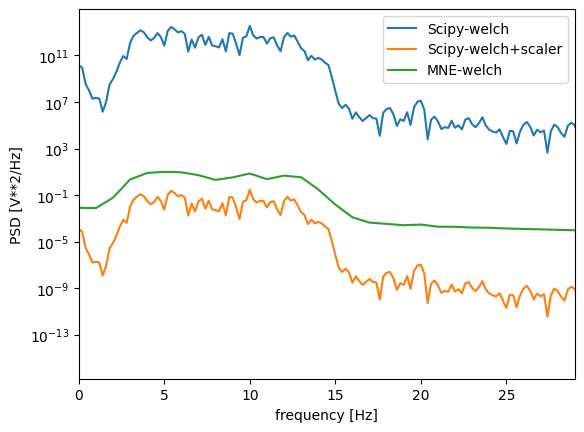

In [150]:
f, Pxx_den = scipy.signal.welch(X[0,0,:], 250, nperseg=1250) #, average='median'
X2 = scaler.fit_transform(X)#, scaler.fit_transform(X/1e6).max()
f2, Pxx_den2 = scipy.signal.welch(X2[0,0,:], 250, nperseg=1250) #, average='median'

# Select f-range
# f, Pxx_den = f[f<12.0], Pxx_den[f<12.0]
# f, Pxx_den = f[4.0<f], Pxx_den[4.0<f]

print(f.shape, Pxx_den.shape)
plt.semilogy(f, Pxx_den)
# plt.semilogy(f[:30], Pxx_den[:30])
plt.xlim([0,29])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')

plt.semilogy(f2, Pxx_den2)

plt.plot(F0[0,0,:30])
plt.legend(['Scipy-welch','Scipy-welch+scaler','MNE-welch'])
plt.show()

In [ ]:
filenames = {'data/Pipo_mix_18_05_1.xdf'} #, 'data/Pipo_mix_18_05_2.xdf'

X_test, y_test = [],[]; tmax=5
for filename in filenames:

    raw = read_xdf(filename, show_plot=False, show_psd=False, bandpass=(4.0, 12.0)) # All ready bandpass?

    epochs = epoching(raw, show_psd=False,
        show_eeg=False,    # set True if wanna see preview of all epoch
        tmax=tmax)         # tmax=5 means set epoch duration 5 second

    # Pick only event 2: Left stimuli, 5: Right stimuli
    epochs = epochs['2','5']

    X_test.append((  epochs.get_data() * 1e6)[:,:,:int( tmax*250 )]) # 250 is record sampling rate
    y_test.append(   epochs.events[:, -1])

# Concatenate all data
X_test1 = np.concatenate(X_test)
# F = np.concatenate(F) # We cannot use MNE-epoching in real-time?
# t = np.concatenate(t)
y_test1 = np.concatenate(y_test)

In [ ]:
filenames = {'data/Pipo_mix_18_05_2.xdf'} #, 

X_test, y_test = [],[]; tmax=5
for filename in filenames:

    raw = read_xdf(filename, show_plot=False, show_psd=False, bandpass=(4.0, 12.0)) # All ready bandpass?

    epochs = epoching(raw, show_psd=False,
        show_eeg=False,    # set True if wanna see preview of all epoch
        tmax=tmax)         # tmax=5 means set epoch duration 5 second

    # Pick only event 2: Left stimuli, 5: Right stimuli
    epochs = epochs['2','5']

    X_test.append((  epochs.get_data() * 1e6)[:,:,:int( tmax*250 )]) # 250 is record sampling rate
    y_test.append(   epochs.events[:, -1])

# Concatenate all data
X_test2 = np.concatenate(X_test)
# F = np.concatenate(F) # We cannot use MNE-epoching in real-time?
# t = np.concatenate(t)
y_test2 = np.concatenate(y_test)

In [115]:
list_X_test = (
    (X_test1, y_test1),
    (X_test2, y_test2),
    # (X_test1, enc.fit_transform(y_test1.reshape(-1, 1)).toarray()),
    # (X_test2, enc.fit_transform(y_test2.reshape(-1, 1)).toarray()),
)

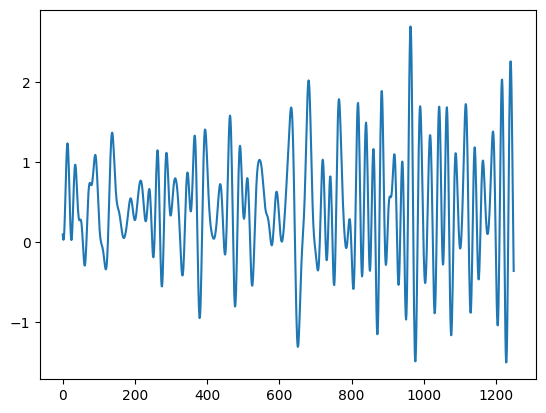

In [103]:
# X.max() / 1e6
# from mne.decoding import Scaler
# scaler = Scaler(scalings='mean')
# X2 = scaler.fit_transform(X)#, scaler.fit_transform(X/1e6).max()
# plt.plot(X2[0,0,:])
# # tf.convert_to_tensor(X / 1e6, dtype=tf.float32)

In [103]:
X_test2.shape, y_test2.shape
# X_test.shape, y_test.shape

((16, 5, 1250), (16,))

In [ ]:
# One hot encoding
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
Y = enc.fit_transform(y.reshape(-1, 1)).toarray()
Y_test = enc.fit_transform(y_test.reshape(-1, 1)).toarray()
# Y = y.copy()
# mp = {2:0, 5:1}
# for i in range(len(Y)):
#     Y[i] = mp[Y[i]]
Y.shape, Y_test.shape

``predict_raw_value, predict_value = CNN.model_predict_classes(np.reshape(send_epoch, (1, 5, 1250)))``

### **Models**

In [91]:
"""Inference models"""

import numpy as np
import tensorflow as tf
# Build model
import keras
from keras.models import Model, Sequential
from keras.layers import  Input, Dense,Dropout, Conv1D, MaxPooling1D, Flatten,BatchNormalization
from keras.optimizers import Adam
from keras import backend as K   
from mne.decoding import Scaler

class FFT_CNNModel(Model):
    """
    Fast Fourier tranform + CNNModel

    setup
    ------------------------------------------------------------
    FFT_CNN = FFT_CNNModel()
    FFT_CNN.model.summary()

    FFT_CNN.load_weights('FFT_CNNModel.h5')


    training
    ------------------------------------------------------------
    X shape should be : (None, 5, 1250)
    Y shape should be : (None, 2)
    
    FFT_CNN.model_train(X, Y)
    (or)
    FFT_CNN.model_train(X, Y, X_val, Y_val)


    eval/inference
    ------------------------------------------------------------
    X shape should be : (None, 5, 1250)
    
    predictions          = FFT_CNN.model_predict(X_test)
    (or)
    predictions, classes = FFT_CNN.model_predict_classes(X_test)


    """
    def __init__(self, inputshape=None, preprocess_scalar=True, preprocess_fft=True, preprocess_fft4to12=False, preprocess_reduceCh=False, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self._name = ('n' if preprocess_scalar else '') + ('FFT_' if preprocess_fft else '') + ('4to12_' if preprocess_fft4to12 else '') + ('3ch_' if preprocess_reduceCh else '') + 'CNNModel'

        # Input layer shape ----------------------------------------------------
        if not inputshape:
            self.inputshape = (
                5 if not preprocess_reduceCh else 3, # 3: O1, O2, Oz
                1250 if not preprocess_fft else (626 if not preprocess_fft4to12 else 39))
        else:
            self.inputshape = inputshape

        # Setup proprocessing method -------------------------------------------
        self.preprocess_scalar = preprocess_scalar
        self.preprocess_fft = preprocess_fft
        self.preprocess_fft4to12 = preprocess_fft4to12
        self.preprocess_reduceCh = preprocess_reduceCh

        # ----------------------------------------------------------------------

        self.scaler = Scaler(scalings='mean')

        # Parameters
        self.bath_size = 4
        self.train_epochs = 10
        self.upper_threshold = 0.8
        self.lower_threshold = 0.2

        # Define layers
        self.conv1_layer1 = Conv1D(filters=128, kernel_size=3, activation='relu')
        self.bath_norm_layer1 =BatchNormalization(name='batch_norm_layer1')
        self.maxpool_layer1 = MaxPooling1D((2 if not preprocess_reduceCh else 1), name='maxpool_layer1')
        self.dropout_layer1 = Dropout(0.2, name='dropout_layer1')
        self.dense_layer1 = Dense(64, activation='relu', name='dense_layer1')
        self.fatten_layer1 = Flatten(name='fatten_layer1')
        self.dropout_layer2 = Dropout(0.2, name='dropout_layer2')
        self.dense_layer2 = Dense(32, activation='relu', name='dense_layer2')
        self.output_layer = Dense(2, activation='softmax', name='output_layer')

        # Get model
        self.model = self.get_model()

    def get_model(self):

        # Define input
        input_layer = Input(shape=self.inputshape, name='input_layer')

        # Model layers
        x = self.conv1_layer1(input_layer)
        x = self.bath_norm_layer1(x)
        x = self.maxpool_layer1(x)
        x = self.dropout_layer1(x)
        x = self.dense_layer1(x)
        x = self.fatten_layer1(x)
        x = self.dropout_layer2(x)
        x = self.dense_layer2(x)
        output_layer = self.output_layer(x)

        # Model
        model = Model(inputs=input_layer, outputs=output_layer, name=self._name)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        try: 
            model.load_weights(self._name+'.h5')
            print(f'Loaded pretrained {self._name}.h5')
        except:
            print('Warning: no pretrained model')

        return model
    
    def load_weights(self, path):
        self.model.load_weights(path)
    
    def model_train(self, X_train, Y_train, X_val=None, Y_val=None):
        if self.preprocess_reduceCh:
            X_train = X_train[:,:3,:]
            
        if self.preprocess_scalar:
            X_train = self.scaler.fit_transform(X_train)

        # Estimate power spectral density using Welch’s method
        if self.preprocess_fft:
            f, X_train = scipy.signal.welch(X_train[:,:,:], 250, nperseg=X_train.shape[-1]) #, average='median'
            # Select f-range 4.0-12.0Hz
            if self.preprocess_fft4to12:
                f, X_train = f[f<12.0],     X_train[:,:,f<12.0]
                f, X_train = f[4.0<f],      X_train[:,:,4.0<f]

        X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
        Y_train = tf.convert_to_tensor(Y_train, dtype=tf.float32)

        # Callbacks API
        checkpoint_filepath = f'weights/weight-{self._name}.h5'
        self.model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_loss' if X_val is not None else 'loss',
            # monitor='val_accuracy' if X_val is not None else 'accuracy',
            mode='min',
            # mode='max',
            save_best_only=True)
        
        if X_val is None:
            self.model.fit(X_train, Y_train, 
                epochs=self.train_epochs, 
                batch_size=self.bath_size, 
                callbacks=[self.model_checkpoint_callback],
                verbose=1)
        else:
            if self.preprocess_reduceCh:
                X_val = X_val[:,:3,:]
                
            if self.preprocess_scalar:
                X_val = self.scaler.fit_transform(X_val)
            
            if self.preprocess_fft:
                f, X_val = scipy.signal.welch(X_val[:,:,:], 250, nperseg=X_val.shape[-1]) #, average='median'
                # Select f-range 4.0-12.0Hz
                if self.preprocess_fft4to12:
                    f, X_val = f[f<12.0],   X_val[:,:,f<12.0]
                    f, X_val = f[4.0<f],    X_val[:,:,4.0<f]

            X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
            Y_val = tf.convert_to_tensor(Y_val, dtype=tf.float32)

            self.model.fit(X_train, Y_train, 
                epochs=self.train_epochs, 
                batch_size=self.bath_size, 
                callbacks=[self.model_checkpoint_callback],
                validation_data=(X_val, Y_val),
                verbose=1)
        
        # The model weights (that are considered the best) are loaded into the
        # model.
        self.model.load_weights(checkpoint_filepath)
        self.model.save(f'weights/{self._name}.h5')

    def model_predict(self, X_test):
        if self.preprocess_reduceCh:
            X_test = X_test[:,:3,:]
            
        if self.preprocess_scalar:
            X_test = self.scaler.fit_transform(X_test)

        # Estimate power spectral density using Welch’s method
        if self.preprocess_fft:
            f, X_test = scipy.signal.welch(X_test[:,:,:], 250, nperseg=X_test.shape[-1]) #, average='median'
            # Select f-range 4.0-12.0Hz
            if self.preprocess_fft4to12:
                f, X_test = f[f<12.0],      X_test[:,:,f<12.0]
                f, X_test = f[4.0<f],       X_test[:,:,4.0<f]
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

        return self.model.predict(X_test)
    
    def model_predict_classes(self, X_test):
        if self.preprocess_reduceCh:
            X_test = X_test[:,:3,:]
            
        if self.preprocess_scalar:
            X_test = self.scaler.fit_transform(X_test)
        
        # Estimate power spectral density using Welch’s method
        if self.preprocess_fft:
            f, X_test = scipy.signal.welch(X_test[:,:,:], 250, nperseg=X_test.shape[-1]) #, average='median'
            # Select f-range 4.0-12.0Hz
            if self.preprocess_fft4to12:
                f, X_test = f[f<12.0],     X_test[:,:,f<12.0]
                f, X_test = f[4.0<f],      X_test[:,:,4.0<f]
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
        
        pred = self.model.predict(X_test)
        classout = np.argmax(pred, axis=1)
        return pred, classout

class DenseModel(Model):
    """
    1-Dense layer Model (Logistic regression)

    setup
    ------------------------------------------------------------
    # simple usage
    DENSE = DenseModel()

    # advance usage
    DENSE = DenseModel(         # Preprocessing options
        preprocess_scalar=True,     # normalize
        preprocess_fft=True,        # fast-fourier
        preprocess_fft4to12=False,  # fast-fourier + filter just 4-12Hz
        preprocess_reduceCh=False,  # channel reduction from 5 to 3 channels (O1,Oz,O2)
    )

    DENSE.model.summary()

    DENSE.load_weights('nFFT_CNNModel.h5')


    training
    ------------------------------------------------------------
    X shape should be : (None, 5, 1250)
    Y shape should be : (None, 2)
    
    DENSE.model_train(X, Y)
    (or)
    DENSE.model_train(X, Y, X_val, Y_val)


    eval/inference
    ------------------------------------------------------------
    X shape should be : (None, 5, 1250)
    
    predictions          = DENSE.model_predict(X_test)
    (or)
    predictions, classes = DENSE.model_predict_classes(X_test)


    """
    def __init__(self, inputshape=None, preprocess_scalar=True, preprocess_fft=True, preprocess_fft4to12=False, preprocess_reduceCh=False, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self._name = ('n' if preprocess_scalar else '') + ('FFT_' if preprocess_fft else '') + ('4to12_' if preprocess_fft4to12 else '') + ('3ch_' if preprocess_reduceCh else '') + 'DenseModel'

        # Input layer shape ----------------------------------------------------
        if not inputshape:
            self.inputshape = (
                5 if not preprocess_reduceCh else 3, # 3: O1, O2, Oz
                1250 if not preprocess_fft else (626 if not preprocess_fft4to12 else 39))
        else:
            self.inputshape = inputshape

        # Setup proprocessing method -------------------------------------------
        self.preprocess_scalar = preprocess_scalar
        self.preprocess_fft = preprocess_fft
        self.preprocess_fft4to12 = preprocess_fft4to12
        self.preprocess_reduceCh = preprocess_reduceCh

        # ----------------------------------------------------------------------

        self.scaler = Scaler(scalings='mean')

        # Parameters
        self.bath_size = 4
        self.train_epochs = 10
        self.upper_threshold = 0.8
        self.lower_threshold = 0.2

        # self.conv1_layer1 = Conv1D(filters=128, kernel_size=3, activation='relu')
        # self.bath_norm_layer1 =BatchNormalization(name='batch_norm_layer1')
        # self.maxpool_layer1 = MaxPooling1D((2 if not preprocess_reduceCh else 1), name='maxpool_layer1')
        # self.dropout_layer1 = Dropout(0.2, name='dropout_layer1')
        # self.dense_layer1 = Dense(64, activation='relu', name='dense_layer1')
        # self.fatten_layer1 = Flatten(name='fatten_layer1')
        # self.dropout_layer2 = Dropout(0.2, name='dropout_layer2')
        # self.dense_layer2 = Dense(32, activation='relu', name='dense_layer2')
        # self.output_layer = Dense(2, activation='softmax', name='output_layer')

        # Define layers
        self.flatten = Flatten(input_shape=self.inputshape)
        self.dense_layer1 = Dense(units=2, activation='softmax')

        # Get model
        self.model = self.get_model()

    def get_model(self):

        # Define input
        # input_layer = Input(shape=self.inputshape, name='input_layer')

        # Model layers
        # x = self.conv1_layer1(input_layer)
        # x = self.bath_norm_layer1(x)
        # x = self.maxpool_layer1(x)
        # x = self.dropout_layer1(x)
        # x = self.dense_layer1(x)
        # x = self.fatten_layer1(x)
        # x = self.dropout_layer2(x)
        # x = self.dense_layer2(x)
        # output_layer = self.output_layer(x)

        # Define the model architecture
        model = Sequential()
        # model.add(Dense(units=64, activation='relu', input_shape=(input_dim,)))
        model.add(self.flatten)
        model.add(self.dense_layer1)

        # Model
        # model = Model(inputs=input_layer, outputs=output_layer, name=self._name)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        try: 
            model.load_weights(self._name+'.h5')
            print(f'Loaded pretrained {self._name}.h5')
        except:
            print('Warning: no pretrained model')

        return model
    
    def load_weights(self, path):
        self.model.load_weights(path)
    
    def model_train(self, X_train, Y_train, X_val=None, Y_val=None):
        if self.preprocess_reduceCh:
            X_train = X_train[:,:3,:]
            
        if self.preprocess_scalar:
            X_train = self.scaler.fit_transform(X_train)

        # Estimate power spectral density using Welch’s method
        if self.preprocess_fft:
            f, X_train = scipy.signal.welch(X_train[:,:,:], 250, nperseg=X_train.shape[-1]) #, average='median'
            # Select f-range 4.0-12.0Hz
            if self.preprocess_fft4to12:
                f, X_train = f[f<12.0],     X_train[:,:,f<12.0]
                f, X_train = f[4.0<f],      X_train[:,:,4.0<f]

        X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
        Y_train = tf.convert_to_tensor(Y_train, dtype=tf.float32)

        # Callbacks API
        checkpoint_filepath = f'weights/weight-{self._name}.h5'
        self.model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_loss' if X_val is not None else 'loss',
            # monitor='val_accuracy' if X_val is not None else 'accuracy',
            mode='min',
            # mode='max',
            save_best_only=True)
        
        if X_val is None:
            self.model.fit(X_train, Y_train, 
                epochs=self.train_epochs, 
                batch_size=self.bath_size, 
                callbacks=[self.model_checkpoint_callback],
                verbose=1)
        else:
            if self.preprocess_reduceCh:
                X_val = X_val[:,:3,:]
                
            if self.preprocess_scalar:
                X_val = self.scaler.fit_transform(X_val)
            
            if self.preprocess_fft:
                f, X_val = scipy.signal.welch(X_val[:,:,:], 250, nperseg=X_val.shape[-1]) #, average='median'
                # Select f-range 4.0-12.0Hz
                if self.preprocess_fft4to12:
                    f, X_val = f[f<12.0],   X_val[:,:,f<12.0]
                    f, X_val = f[4.0<f],    X_val[:,:,4.0<f]

            X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
            Y_val = tf.convert_to_tensor(Y_val, dtype=tf.float32)

            self.model.fit(X_train, Y_train, 
                epochs=self.train_epochs, 
                batch_size=self.bath_size, 
                callbacks=[self.model_checkpoint_callback],
                validation_data=(X_val, Y_val),
                verbose=1)
        
        # The model weights (that are considered the best) are loaded into the
        # model.
        self.model.load_weights(checkpoint_filepath)
        self.model.save(f'weights/{self._name}.h5')

    def model_predict(self, X_test):
        if self.preprocess_reduceCh:
            X_test = X_test[:,:3,:]
            
        if self.preprocess_scalar:
            X_test = self.scaler.fit_transform(X_test)

        # Estimate power spectral density using Welch’s method
        if self.preprocess_fft:
            f, X_test = scipy.signal.welch(X_test[:,:,:], 250, nperseg=X_test.shape[-1]) #, average='median'
            # Select f-range 4.0-12.0Hz
            if self.preprocess_fft4to12:
                f, X_test = f[f<12.0],      X_test[:,:,f<12.0]
                f, X_test = f[4.0<f],       X_test[:,:,4.0<f]
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

        return self.model.predict(X_test)
    
    def model_predict_classes(self, X_test):
        if self.preprocess_reduceCh:
            X_test = X_test[:,:3,:]
            
        if self.preprocess_scalar:
            X_test = self.scaler.fit_transform(X_test)
        
        # Estimate power spectral density using Welch’s method
        if self.preprocess_fft:
            f, X_test = scipy.signal.welch(X_test[:,:,:], 250, nperseg=X_test.shape[-1]) #, average='median'
            # Select f-range 4.0-12.0Hz
            if self.preprocess_fft4to12:
                f, X_test = f[f<12.0],     X_test[:,:,f<12.0]
                f, X_test = f[4.0<f],      X_test[:,:,4.0<f]
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
        
        pred = self.model.predict(X_test)
        classout = np.argmax(pred, axis=1)
        return pred, classout



### **Train**

In [112]:
from sklearn.model_selection import train_test_split

X, X_val, Y, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [95]:
temp = DenseModel(
    # preprocess_fft=False,
    # preprocess_scalar=False,
    preprocess_fft4to12=True, 
    preprocess_reduceCh=True,
)
temp.model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 117)               0         
                                                                 
 dense_4 (Dense)             (None, 2)                 236       
                                                                 
Total params: 236
Trainable params: 236
Non-trainable params: 0
_________________________________________________________________


In [97]:
MODELs = {
    'CNN'               : FFT_CNNModel(preprocess_fft=False, preprocess_scalar=False),
    'nCNN'              : FFT_CNNModel(preprocess_fft=False),
    'FFT_CNN'           : FFT_CNNModel(preprocess_scalar=False),
    'nFFT_CNN'          : FFT_CNNModel(),
    'nFFT_4to12_CNN'    : FFT_CNNModel(preprocess_fft4to12=True),
    'nFFT_3ch_CNN'      : FFT_CNNModel(preprocess_reduceCh=True),
    'nFFT_4to12_3ch_CNN': FFT_CNNModel(preprocess_fft4to12=True, preprocess_reduceCh=True),
    'n3ch_Dense'        : DenseModel(preprocess_reduceCh=True),
    'n4to12_3ch_Dense'  : DenseModel(preprocess_fft4to12=True, preprocess_reduceCh=True),
}

In [203]:
# from models import CNNModel

CNN = CNNModel()
CNN.model.summary()

Model: "CNNModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 5, 1250)]         0         
                                                                 
 conv1d_15 (Conv1D)          (None, 3, 128)            480128    
                                                                 
 batch_norm_layer1 (BatchNor  (None, 3, 128)           512       
 malization)                                                     
                                                                 
 maxpool_layer1 (MaxPooling1  (None, 1, 128)           0         
 D)                                                              
                                                                 
 dropout_layer1 (Dropout)    (None, 1, 128)            0         
                                                                 
 dense_layer1 (Dense)        (None, 1, 64)             825

In [113]:
X.shape, Y.shape, X_val.shape, Y_val.shape

((38, 5, 1250), (38, 2), (10, 5, 1250), (10, 2))

In [114]:
for model_name in MODELs.keys():
    print(model_name)
    MODELs[model_name].model_train(X, Y, X_val, Y_val)

CNN
Epoch 1/10
10/10 [==============================] - 2s 42ms/step - loss: 1.1656 - accuracy: 0.5789 - val_loss: 4.3434 - val_accuracy: 0.6000
Epoch 2/10
10/10 [==============================] - 0s 25ms/step - loss: 0.5804 - accuracy: 0.7368 - val_loss: 1.9572 - val_accuracy: 0.5000
Epoch 3/10
10/10 [==============================] - 0s 32ms/step - loss: 0.4782 - accuracy: 0.7895 - val_loss: 0.4132 - val_accuracy: 0.9000
Epoch 4/10
10/10 [==============================] - 0s 24ms/step - loss: 0.4750 - accuracy: 0.7105 - val_loss: 0.2919 - val_accuracy: 0.8000
Epoch 5/10
10/10 [==============================] - 0s 45ms/step - loss: 0.1864 - accuracy: 0.9474 - val_loss: 0.1555 - val_accuracy: 0.9000
Epoch 6/10
10/10 [==============================] - 0s 22ms/step - loss: 0.1218 - accuracy: 0.9737 - val_loss: 0.1109 - val_accuracy: 0.9000
Epoch 7/10
10/10 [==============================] - 0s 13ms/step - loss: 0.1516 - accuracy: 0.9211 - val_loss: 0.1280 - val_accuracy: 1.0000
Epoch 8/1

In [173]:
# The model weights (that are considered the best) are loaded into the
# model.
FFT_CNN.load_weights('weights\FFT_CNNModel.h5')

In [204]:
CNN.train_epochs = 10
CNN.model_train(X, Y)

Epoch 1/10
10/10 [==============================] - 1s 9ms/step - loss: 0.7233 - accuracy: 0.6053
Epoch 2/10
10/10 [==============================] - 0s 9ms/step - loss: 0.5182 - accuracy: 0.7368
Epoch 3/10
10/10 [==============================] - 0s 9ms/step - loss: 0.3839 - accuracy: 0.8421
Epoch 4/10
10/10 [==============================] - 0s 9ms/step - loss: 0.2461 - accuracy: 0.9211
Epoch 5/10
10/10 [==============================] - 0s 9ms/step - loss: 0.1326 - accuracy: 0.9737
Epoch 6/10
10/10 [==============================] - 0s 9ms/step - loss: 0.3235 - accuracy: 0.8421
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: 0.1777 - accuracy: 0.9474
Epoch 8/10
10/10 [==============================] - 0s 9ms/step - loss: 0.2101 - accuracy: 0.8947
Epoch 9/10
10/10 [==============================] - 0s 9ms/step - loss: 0.1663 - accuracy: 0.8947
Epoch 10/10
10/10 [==============================] - 0s 9ms/step - loss: 0.1297 - accuracy: 0.9474


In [175]:
out = FFT_CNN.model_predict_classes(X_test)
out

1/1 [==============================] - 0s 21ms/step


(array([[0.3749446 , 0.6250554 ],
        [0.68913627, 0.3108637 ],
        [0.71301454, 0.28698546],
        [0.3618163 , 0.6381837 ],
        [0.71964484, 0.28035513],
        [0.5172071 , 0.48279285],
        [0.40382996, 0.59617007],
        [0.7048275 , 0.2951725 ],
        [0.72266346, 0.27733654],
        [0.48822248, 0.5117775 ],
        [0.7217922 , 0.27820775],
        [0.3796649 , 0.6203351 ],
        [0.49255297, 0.50744706],
        [0.6626619 , 0.33733806],
        [0.76005656, 0.23994349],
        [0.50833744, 0.4916625 ],
        [0.7508699 , 0.24913009],
        [0.5560977 , 0.44390234],
        [0.48262364, 0.51737636],
        [0.73190373, 0.26809624],
        [0.6914132 , 0.30858684],
        [0.27518785, 0.7248122 ],
        [0.5852527 , 0.4147473 ],
        [0.72726226, 0.2727377 ],
        [0.54571354, 0.4542865 ],
        [0.7606296 , 0.23937039],
        [0.72532505, 0.27467495],
        [0.49472287, 0.5052771 ],
        [0.8090259 , 0.19097412],
        [0.552

### **Evaluate the model**

In [39]:
from sklearn.metrics import classification_report, accuracy_score

In [177]:
predictions = FFT_CNN.model_predict(X_test)
predictions

1/1 [==============================] - 0s 22ms/step


array([[0.3749446 , 0.6250554 ],
       [0.68913627, 0.3108637 ],
       [0.71301454, 0.28698546],
       [0.3618163 , 0.6381837 ],
       [0.71964484, 0.28035513],
       [0.5172071 , 0.48279285],
       [0.40382996, 0.59617007],
       [0.7048275 , 0.2951725 ],
       [0.72266346, 0.27733654],
       [0.48822248, 0.5117775 ],
       [0.7217922 , 0.27820775],
       [0.3796649 , 0.6203351 ],
       [0.49255297, 0.50744706],
       [0.6626619 , 0.33733806],
       [0.76005656, 0.23994349],
       [0.50833744, 0.4916625 ],
       [0.7508699 , 0.24913009],
       [0.5560977 , 0.44390234],
       [0.48262364, 0.51737636],
       [0.73190373, 0.26809624],
       [0.6914132 , 0.30858684],
       [0.27518785, 0.7248122 ],
       [0.5852527 , 0.4147473 ],
       [0.72726226, 0.2727377 ],
       [0.54571354, 0.4542865 ],
       [0.7606296 , 0.23937039],
       [0.72532505, 0.27467495],
       [0.49472287, 0.5052771 ],
       [0.8090259 , 0.19097412],
       [0.55215305, 0.447847  ],
       [0.

In [193]:
# threshold = 0.5
predictions_label = np.where(
    np.where(predictions > 0.5, 1, 0).argmax(axis=1) == 1, 5, 2
)
print('predict:', predictions_label)
print('label  :', y_test)

predict: [5 2 2 5 2 2 5 2 2 5 2 5 5 2 2 2 2 2 5 2 2 5 2 2 2 2 2 5 2 2 2 2]
label  : [5 2 2 5 2 5 5 2 2 5 2 5 5 2 2 5 2 5 5 2 2 5 5 2 5 2 2 5 2 5 5 2]


In [194]:
# Classification report
print(classification_report(y_test, predictions_label))

              precision    recall  f1-score   support

           2       0.70      1.00      0.82        16
           5       1.00      0.56      0.72        16

    accuracy                           0.78        32
   macro avg       0.85      0.78      0.77        32
weighted avg       0.85      0.78      0.77        32



In [207]:
predictions = CNN.model_predict(X_test)
predictions

# threshold = 0.5
predictions_label = np.where(
    np.where(predictions > 0.5, 1, 0).argmax(axis=1) == 1, 5, 2
)
print('predict:', predictions_label)
print('label  :', y_test)

# Classification report
print(classification_report(y_test, predictions_label))

1/1 [==============================] - 0s 23ms/step
predict: [5 5 2 5 5 2 2 5 5 5 2 5 5 5 5 5 5 2 5 2 5 5 5 2 5 5 5 5 5 2 5 5]
label  : [5 2 2 5 2 5 5 2 2 5 2 5 5 2 2 5 2 5 5 2 2 5 5 2 5 2 2 5 2 5 5 2]
              precision    recall  f1-score   support

           2       0.50      0.25      0.33        16
           5       0.50      0.75      0.60        16

    accuracy                           0.50        32
   macro avg       0.50      0.50      0.47        32
weighted avg       0.50      0.50      0.47        32



In [ ]:
CNN.model.save('CNNNorm.h5')

Multiple Models

##### ALL

In [38]:
df = pd.DataFrame(columns=['model', 'acc'])
df

,model,acc


In [42]:
df = pd.DataFrame(columns=['model', 'acc'])
c = 0
for model_name in MODELs.keys():
    print(model_name)
    predictions = MODELs[model_name].model_predict(X_test)
    # threshold = 0.5
    predictions_label = np.where(
        np.where(predictions > 0.5, 1, 0).argmax(axis=1) == 1, 5, 2
    )
    print('predict:', predictions_label)
    print('label  :', y_test)
        
    # Classification report
    print(classification_report(y_test, predictions_label))

    df.loc[len(df.index)] = [model_name, accuracy_score(y_test, predictions_label)]
    c+=1
df

CNN
1/1 [==============================] - 0s 26ms/step
predict: [5 5 5 5 5 2 2 5 5 5 5 2 5 5 5 5 2 5 5 2 2 5 5 2 5 5 5 5 5 5 5 5]
label  : [5 2 2 5 2 5 5 2 2 5 2 5 5 2 2 5 2 5 5 2 2 5 5 2 5 2 2 5 2 5 5 2]
              precision    recall  f1-score   support

           2       0.57      0.25      0.35        16
           5       0.52      0.81      0.63        16

    accuracy                           0.53        32
   macro avg       0.55      0.53      0.49        32
weighted avg       0.55      0.53      0.49        32

nCNN
1/1 [==============================] - 0s 35ms/step
predict: [5 5 2 5 5 2 5 5 5 5 5 5 2 5 5 5 2 5 5 5 5 5 5 2 5 5 5 5 5 2 5 5]
label  : [5 2 2 5 2 5 5 2 2 5 2 5 5 2 2 5 2 5 5 2 2 5 5 2 5 2 2 5 2 5 5 2]
              precision    recall  f1-score   support

           2       0.50      0.19      0.27        16
           5       0.50      0.81      0.62        16

    accuracy                           0.50        32
   macro avg       0.50      0.50      0.4

,model,acc
0,CNN,0.53125
1,nCNN,0.50000
2,FFT_CNN,0.87500
3,nFFT_CNN,1.00000
4,nFFT_4to12_CNN,0.93750
5,nFFT_3ch_CNN,1.00000
6,nFFT_4to12_3ch_CNN,0.96875


In [87]:
df.to_csv(r'results\exp3-model+acc-multipleCNNs.csv')

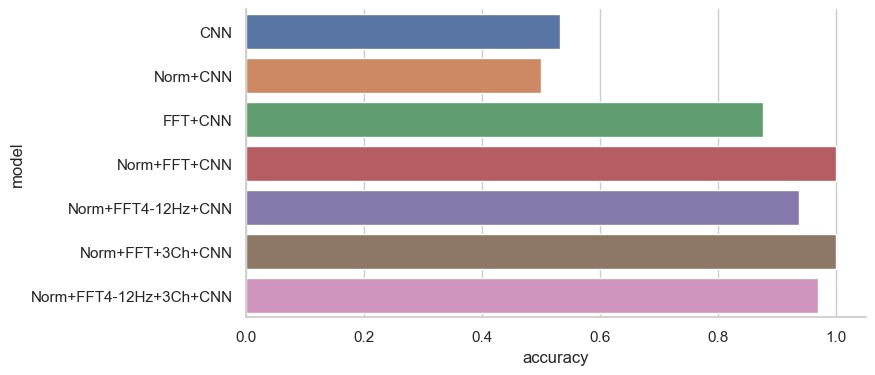

In [86]:
# sns.set_theme(style="whitegrid", palette="Set1") #"OrRd" Set1, Set2, Pastel1
sns.set_theme(style="whitegrid")
# sns.set_palette("rocket_r")

# fig, ax = plt.subplots(ncols=2, figsize=[12,3])
# sns.barplot(data=results, x='AUC', y='Method', capsize=.2, ax=ax[0],
#         errorbar=('ci', 68),
#         # default ci=95 is ~1.96 standard errors, and ci=68 is ~1 standard error
#     )
# ax[0].set_xlim(0.5, 1); ax[0].set_title('AUC')
# sns.despine()

fig, ax = plt.subplots(ncols=1, figsize=[8,4])
sns.barplot(data=df, x='acc', y='model', ax=ax,
        # errorbar=('ci', 68), capsize=.2
        # default ci=95 is ~1.96 standard errors, and ci=68 is ~1 standard error
    )
# ax[1].set_xlim(0.5, 1); ax[1].set_title('Accuracy'); ax[1].set_yticks([])
ax.set_yticklabels((
    'CNN',
    'Norm+CNN',
    'FFT+CNN',
    'Norm+FFT+CNN',
    'Norm+FFT4-12Hz+CNN',
    'Norm+FFT+3Ch+CNN',
    'Norm+FFT4-12Hz+3Ch+CNN',
))
ax.set_xlabel('accuracy')
sns.despine()
plt.show()

#### Iteration

In [116]:
df = pd.DataFrame(columns=['model', 'acc'])
c = 0
for model_name in MODELs.keys():
    print(model_name)

    for X_test, y_test in list_X_test:
            
        predictions = MODELs[model_name].model_predict(X_test)
        # threshold = 0.5
        predictions_label = np.where(
            np.where(predictions > 0.5, 1, 0).argmax(axis=1) == 1, 5, 2
        )
        print('predict:', predictions_label)
        print('label  :', y_test)
            
        # Classification report
        print(classification_report(y_test, predictions_label))

        df.loc[len(df.index)] = [model_name, accuracy_score(y_test, predictions_label)]
        c+=1
df

CNN
1/1 [==============================] - 0s 146ms/step
predict: [5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5]
label  : [5 2 2 5 2 5 5 2 2 5 2 5 5 2 2 5]
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         8
           5       0.47      0.88      0.61         8

    accuracy                           0.44        16
   macro avg       0.23      0.44      0.30        16
weighted avg       0.23      0.44      0.30        16

1/1 [==============================] - 0s 24ms/step
predict: [2 5 5 2 5 5 5 2 5 5 5 5 5 5 5 2]
label  : [2 5 5 2 2 5 5 2 5 2 2 5 2 5 5 2]
              precision    recall  f1-score   support

           2       1.00      0.50      0.67         8
           5       0.67      1.00      0.80         8

    accuracy                           0.75        16
   macro avg       0.83      0.75      0.73        16
weighted avg       0.83      0.75      0.73        16

nCNN
1/1 [==============================] - 0s 121ms/step
predict

,model,acc
0,CNN,0.4375
1,CNN,0.7500
2,nCNN,0.3125
3,nCNN,0.6875
4,FFT_CNN,0.6875
5,FFT_CNN,0.5625
6,nFFT_CNN,1.0000
7,nFFT_CNN,1.0000
8,nFFT_4to12_CNN,1.0000
9,nFFT_4to12_CNN,0.5625


In [117]:
df.to_csv(r'results\exp3-model+acc_split-multipleCNNs+Dense.csv')

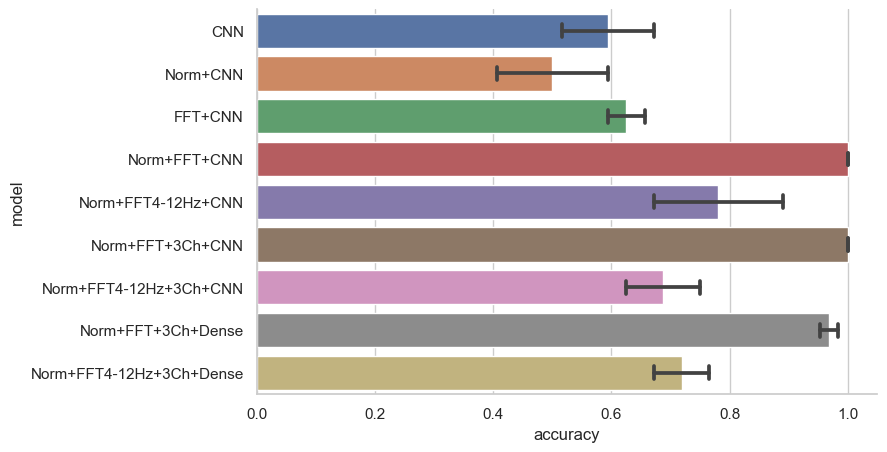

In [127]:
# sns.set_theme(style="whitegrid", palette="Set1") #"OrRd" Set1, Set2, Pastel1
sns.set_theme(style="whitegrid")
# sns.set_palette("rocket_r")

# fig, ax = plt.subplots(ncols=2, figsize=[12,3])
# sns.barplot(data=results, x='AUC', y='Method', capsize=.2, ax=ax[0],
#         errorbar=('ci', 68),
#         # default ci=95 is ~1.96 standard errors, and ci=68 is ~1 standard error
#     )
# ax[0].set_xlim(0.5, 1); ax[0].set_title('AUC')
# sns.despine()

fig, ax = plt.subplots(ncols=1, figsize=[8,5])
sns.barplot(data=df, x='acc', y='model', ax=ax,
        capsize=.3,
        # errorbar="sd", 
        errorbar=('pi', 50), 
        # errorbar=('ci', 68), 
        # default ci=95 is ~1.96 standard errors, and ci=68 is ~1 standard error
    )
# ax[1].set_xlim(0.5, 1); ax[1].set_title('Accuracy'); ax[1].set_yticks([])
ax.set_yticklabels((
    'CNN',
    'Norm+CNN',
    'FFT+CNN',
    'Norm+FFT+CNN',
    'Norm+FFT4-12Hz+CNN',
    'Norm+FFT+3Ch+CNN',
    'Norm+FFT4-12Hz+3Ch+CNN',
    'Norm+FFT+3Ch+Dense',
    'Norm+FFT4-12Hz+3Ch+Dense',
))
ax.set_xlabel('accuracy')
sns.despine()
plt.show()